# Sentiment Analysis with Sagemaker linear learner



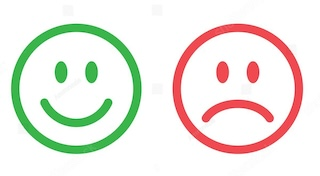

----------

## Install Libraries

In [ ]:
!pip install s3fs boto3 sagemaker Sastrawi

## Import Libraries

In [42]:
import os
import re
import io
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import boto3
import joblib

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
)

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

import sagemaker
from sagemaker import Session, get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
from sagemaker import image_uris

import warnings
warnings.filterwarnings('ignore')

Get Session and Role

In [43]:
sagemaker_session = Session()
role = get_execution_role()

## Load Dataset

In [44]:
# S3 config
bucket_name = "sentiments890"
file_key = "dataset/ig_cyber_bullying.csv"

s3_uri = f"s3://{bucket_name}/{file_key}"

In [45]:
df = pd.read_csv(s3_uri)
pd.set_option('display.max_colwidth', None)

df.sample(n=10)

,Id,Sentiment,Instagram Comment Text
243,244,positive,Setiap caption yang di buat ibu..dan setiap kali saya membaca captionnya secara tidak langsung saya belajar bahasa Inggris ... Terima kasih ibu... Secara personal saya tdk mengenal ibu Anie tp saya yakin betapa bangganya Anak Cucumu bisa kamu didik ibu menjadi generasi bangsa yang mandiri dan unggul ... Sehat terus ibu .. Semoga Cinta Kasih dalam Keluarga selalu engkau tebarkan untuk mereka ...
366,367,positive,salut ma bunda <USERNAME> .. mskipun ibu sambung.. tpi sellu jdi org yg plingbdpan mmbela aurel n azriel dri pra hatters..
28,29,negative,Dan lebih bagus lagi kalo mingkem aja hahahahahaha jahatnya akuuu
390,391,positive,"Mereka hanya mencari rejeki utk keluarganya, kalau ada yg merasa tdk berkenan tolong jangan menggunakan kekerasan"
268,269,positive,Di ulang berkali kali sampet gak percaya klo ini suara aslinya. Bagus bgt ??
320,321,positive,Ganteng yesss. Mami cuco deh sama babang. Semoga langgeng ya unchhh lope mami
235,236,positive,"Semangat ya eyang habibie, sehat selalu, selalu dlm lindungan Allah, ambisinya selalu kuat dlm melakukan segala hal. Kereeeennnnn. Semoga bnyk penurus2 bangsa sprti eyang Habibie ????????????????????????"
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya keguguran dgn pake hijab syar'i yg lo bilang bayi nya kepanasan didalem gak ada hubungan nya woyyyy!! Otak sama jempol lo gak singkron sih ya jadinya asal nulis komentar!
180,181,negative,"<USERNAME> iya""km bening, kelewat bening jadi buluk kan ya mbak ?? mbaknya baru nelen apasih komen kaya gini? Apa baru kesurupan ?"
312,313,positive,"Nah ini baru keren, daripada mba mba superman wkwkwk"


Note: Dataset source https://github.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia

## Exploratory Data Analysis (EDA)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      400 non-null    int64 
 1   Sentiment               400 non-null    object
 2   Instagram Comment Text  400 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.5+ KB


In [47]:
df.columns

Index(['Id', 'Sentiment', 'Instagram Comment Text'], dtype='object')

### Visualize

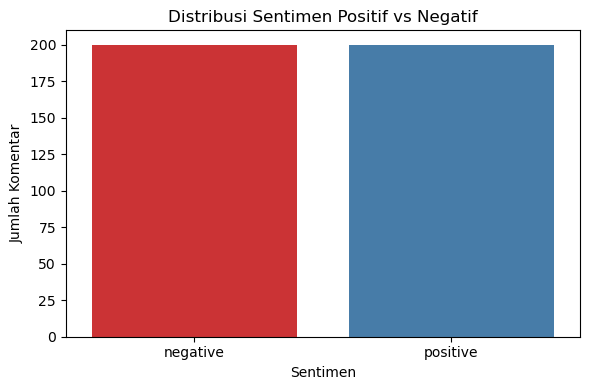

In [48]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Sentiment', palette='Set1')

# Add styling
plt.title('Distribusi Sentimen Positif vs Negatif')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Komentar')
plt.xticks(rotation=0)
plt.tight_layout()

# Show plot
plt.show()

In [49]:
sentiment_counts = df['Sentiment'].value_counts()
sentiment_counts

Sentiment
negative    200
positive    200
Name: count, dtype: int64

## Data Preprocessing

Cek missing values

In [50]:
df.isna().sum()

Id                        0
Sentiment                 0
Instagram Comment Text    0
dtype: int64

Cek data duplikat

In [51]:
duplicates = df[df.duplicated()]

print(f"Jumlah data duplikat: {duplicates.shape[0]}")

Jumlah data duplikat: 0


In [52]:
df.shape

(400, 3)

In [53]:
# Hapus spasi di kolom dan ganti dengan "_"
df.rename(columns={'Instagram Comment Text': 'Instagram_Comment_Text'}, inplace=True)

### Feature Engineering

Hapus kolom id

In [54]:
df.drop(columns=['Id'], inplace=True)

Encoding

In [55]:
encoder = LabelEncoder()
df['Sentiment_Encoded'] = encoder.fit_transform(df['Sentiment'])

In [56]:
df.sample(n=10) # dengan random sampling

,Sentiment,Instagram_Comment_Text,Sentiment_Encoded
258,positive,Yatuhan suaranyaaaaaaa bagus bangetttttttt,1
297,positive,Keluarga ter-humble ter-sempurna ter-sederhana dan engga pernah sok terlihat kaya dan ga pnah manja pake pesawat jet pribadi kayak yg lain lain ??????????,1
277,positive,Yesssssss !!!!! Bagus bgt !!! ?????? Kids jaman now yg begini yg diksh jempolllll ????????,1
158,negative,Hahhahaha dan sesungguhnya allah swt melaknat wanita perebut dan pezina dengan suami sah oranglain ????????,0
182,negative,Emang dasar si anak nya aja yg lebay....urusan pribadi di umbar..biar di blow up... hadehh..gunanya whatsapp sms or telp buat apa..suka aneh....,0
153,negative,"langsung saja bilang siapa yg di maksud, klu gini namanya MUNAFIK!",0
81,negative,"Najis..,apalagi d philipine biasa bgt kali,d sana aj bangga..jd perusak moral ko bangga..najis banget liatnya.ckp d sini aj komen ny,dia pngn ngetop lwt nitezerrre.....wkwkwk..ngarep laku",0
334,positive,"Alhamdulillah <USERNAME> gak jadi sama yg ini... engku emran masyaallah ganteng, anteng, sabar, sholeh, penyanyang, senyumnya cute.. baper dech",1
183,negative,"Coba liat bibir mu sayang, seperti pantat ayam. Wajah mu bulukan seperti kentut?? perfectoooo?",0
224,positive,Cantik dan gagah mudahan lancar dampe hari h,1


### Split Data

In [57]:
train_df, test_df = train_test_split(
    df,
    test_size = 0.2, 
    random_state = 42, 
    stratify=df['Sentiment']
)

### Stop Words Removal

In [58]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

Terapkan ke data train

In [59]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = stopword.remove(text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['cleaned_comment'] = train_df['Instagram_Comment_Text'].apply(preprocess_text)

In [60]:
train_df

,Sentiment,Instagram_Comment_Text,Sentiment_Encoded,cleaned_comment
390,positive,"Mereka hanya mencari rejeki utk keluarganya, kalau ada yg merasa tdk berkenan tolong jangan menggunakan kekerasan",1,hanya mencari rejeki utk keluarganya kalau yg merasa tdk berkenan jangan menggunakan kekerasan
326,positive,Jangan di dengar kata 2 yg menyakitkan hati lebih baik tenang jalanin aja dengan pilihan andah sendiri bahagia itu biasanya ada di kata hatimu maju trus dan sukses bersama pasangan mu,1,jangan dengar kata 2 yg menyakitkan hati lebih baik tenang jalanin aja pilihan andah sendiri bahagia biasanya di kata hatimu maju trus sukses bersama pasangan mu
139,negative,Oh ini toh yang kemaren TIDAK MENGHARGAI KARYA ORANG DAN SEENAKNYA BILANG JELEK BANGET... Aduh itu penganten perempuan nya KEKENYANGAN yah... Ampe kembung gitu perut nya... #pepuraLuGU,0,ini yang kemaren menghargai karya orang seenaknya bilang jelek banget aduh penganten perempuan nya kekenyangan yah ampe kembung gitu perut nya pepuralugu
119,negative,"<USERNAME> please lo jangan bela pelakor,ini semua hukuman untuk si muljem karna uda tega recut suami sahabat sendiri,dia lagi menjalani sanksi sosialnya!! kenapa valakor mesti dibenci?? karna biar ga ada valakor"" lainnya di Indonesia,biar musnah sem",0,username please lo jangan bela pelakor semua hukuman si muljem karna uda tega recut suami sahabat sendiri lagi menjalani sanksi sosialnya valakor mesti dibenci karna biar ga valakor lainnya indonesia biar musnah sem
77,negative,Noraaak abiiis... Baru kebeli emas az pamer aplg mainan berlian ciiinnnnn.... ??,0,noraaak abiiis baru kebeli emas az pamer aplg mainan berlian ciiinnnnn
...,...,...,...,...
156,negative,"Wkwkwkwk... Ya Allah ya Tuhan ku knp lah org2 munafik ni tp sok suci, mulan jamela kan ayu ting2 ngikuti jejak a bukan? Wkwkwk <USERNAME>",0,wkwkwkwk allah tuhan ku knp lah org2 munafik ni tp sok suci mulan jamela kan ayu ting2 ngikuti jejak a bukan wkwkwk username
258,positive,Yatuhan suaranyaaaaaaa bagus bangetttttttt,1,yatuhan suaranyaaaaaaa bagus bangetttttttt
49,negative,"Astagah, demen ama cewek dekil kumel. Ibaratnya dari nagita turun ke att. Nagita kaya emas att kaya barlen",0,astagah demen ama cewek dekil kumel ibaratnya nagita turun att nagita kaya emas att kaya barlen
339,positive,"Semoga ga putus lagi ya. Ka bella udah bahagia banget tuh, ga malu??? ??????",1,semoga ga putus ya ka bella udah bahagia banget tuh ga malu


Ganti *Instagram_Comment_text* dengan *cleaned_comment*

In [61]:
train_df.drop(columns=['Instagram_Comment_Text'], inplace=True)
train_df.rename(columns={'cleaned_comment': 'Instagram_Comment_Text'}, inplace=True)

In [62]:
train_df.head()

,Sentiment,Sentiment_Encoded,Instagram_Comment_Text
390,positive,1,hanya mencari rejeki utk keluarganya kalau yg merasa tdk berkenan jangan menggunakan kekerasan
326,positive,1,jangan dengar kata 2 yg menyakitkan hati lebih baik tenang jalanin aja pilihan andah sendiri bahagia biasanya di kata hatimu maju trus sukses bersama pasangan mu
139,negative,0,ini yang kemaren menghargai karya orang seenaknya bilang jelek banget aduh penganten perempuan nya kekenyangan yah ampe kembung gitu perut nya pepuralugu
119,negative,0,username please lo jangan bela pelakor semua hukuman si muljem karna uda tega recut suami sahabat sendiri lagi menjalani sanksi sosialnya valakor mesti dibenci karna biar ga valakor lainnya indonesia biar musnah sem
77,negative,0,noraaak abiiis baru kebeli emas az pamer aplg mainan berlian ciiinnnnn


Pastikan dimensi kolom sama

In [63]:
train_df.shape

(320, 3)

In [64]:
test_df.shape

(80, 3)

## Modeling

In [65]:
# Create vectorizer
vectorizer = TfidfVectorizer(max_features=100) # 100 kata
X_train_tfidf = vectorizer.fit_transform(train_df['Instagram_Comment_Text'])
X_test_tfidf = vectorizer.transform(test_df['Instagram_Comment_Text'])

In [66]:
y_train = train_df['Sentiment_Encoded']
y_test = test_df['Sentiment_Encoded']

In [67]:
# Gabungkan fitur & label (label di kolom pertama)
train_arr = np.hstack([y_train.values.reshape(-1, 1), X_train_tfidf.toarray()])
test_arr = np.hstack([y_test.values.reshape(-1, 1), X_test_tfidf.toarray()])

Upload ke S3

In [68]:
s3 = boto3.client('s3')

prefix='linear-learner-asset'

def upload_to_s3(local_file, bucket, s3_path):
    s3.upload_file(local_file, bucket, s3_path)
    print(f"Sukses upload {local_file} to s3://{bucket}/{s3_path}")

upload_to_s3('asset/train.csv', bucket_name, f'{prefix}/train/train.csv')
upload_to_s3('asset/test.csv', bucket_name, f'{prefix}/test/test.csv')

Sukses upload asset/train.csv to s3://sentiments890/linear-learner-asset/train/train.csv
Sukses upload asset/test.csv to s3://sentiments890/linear-learner-asset/test/test.csv


Simpan fungsi vectorizer

In [69]:
vectorizer_filename = 'tfidf_vectorizer.joblib'
joblib.dump(vectorizer, vectorizer_filename)
s3_path = 'linear-learner-asset/artifact/tfidf_vectorizer.joblib'  # path di S3

s3.upload_file(vectorizer_filename, bucket_name, s3_path)
print(f"Sukses upload {vectorizer_filename} ke s3://{bucket_name}/{s3_path}")

Sukses upload tfidf_vectorizer.joblib ke s3://sentiments890/linear-learner-asset/artifact/tfidf_vectorizer.joblib


Dapatkan container default dari sagemaker

In [70]:
container = image_uris.retrieve(
    'linear-learner',
    sagemaker.Session().boto_region_name,
    '1.5-1'
)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Metode Built-in Algoritma

In [71]:
estimator = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large', # instance yg murah
    output_path=f's3://{bucket_name}/{prefix}/model/output',
    hyperparameters={
        'predictor_type': 'binary_classifier',
        'optimizer': 'auto',
        'mini_batch_size': 16
    }
)

# Channel input
train_data = TrainingInput(f's3://{bucket_name}/{prefix}/train/train.csv', content_type='text/csv')
test_data = TrainingInput(f's3://{bucket_name}/{prefix}/test/test.csv', content_type='text/csv')

Training

In [72]:
estimator.fit({'train': train_data, 'validation': test_data})

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: linear-learner-2025-07-12-01-29-06-040


2025-07-12 01:29:07 Starting - Starting the training job...
2025-07-12 01:29:21 Starting - Preparing the instances for training...
2025-07-12 01:29:45 Downloading - Downloading input data...
2025-07-12 01:30:36 Downloading - Downloading the training image.........
2025-07-12 01:31:52 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/12/2025 01:31:56 INFO 140394514949952] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss':

In [73]:
if estimator.latest_training_job is not None:
    job = estimator.latest_training_job
    metrics = job.describe()['FinalMetricDataList']
    
    wanted_metrics = [
        'train:progress',
        'validation:binary_classification_accuracy',
        'validation:recall',
        'validation:roc_auc_score',
        'validation:precision'
    ]

    for metric in metrics:
        if metric['MetricName'] in wanted_metrics:
            value = round(metric['Value'], 3)
            print(f"{metric['MetricName']}: {value}")

train:progress: 100.0
validation:binary_classification_accuracy: 0.75
validation:recall: 0.725
validation:roc_auc_score: 0.833
validation:precision: 0.763


### Learning Curve

Plot learning curve bisa dilihat melalui **CloudWatch**

### Deploy Model

In [74]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    endpoint_name='linear-learner-v1'
)

INFO:sagemaker:Creating model with name: linear-learner-2025-07-12-01-33-24-473
INFO:sagemaker:Creating endpoint-config with name linear-learner-v1
INFO:sagemaker:Creating endpoint with name linear-learner-v1


------------------!

### Confusion Matrix

In [76]:
X_test_tfidf = vectorizer.transform(test_df['Instagram_Comment_Text'])  # matrix hasil TFIDF
X_test = X_test_tfidf.toarray()

csv_buffer = io.StringIO() # membuat buffer string sementara di memori
pd.DataFrame(X_test).to_csv(csv_buffer, header=False, index=False)
X_test_csv_string = csv_buffer.getvalue()

result = predictor.predict(
    X_test_csv_string,
    initial_args={"ContentType": "text/csv"}
)

In [77]:
response_str = result.decode("utf-8")
data = json.loads(response_str)  # data adalah dict dengan key "predictions"

# Ambil label prediksi dari setiap item di dalam data["predictions"]
y_pred = np.array([int(item["predicted_label"]) for item in data["predictions"]])

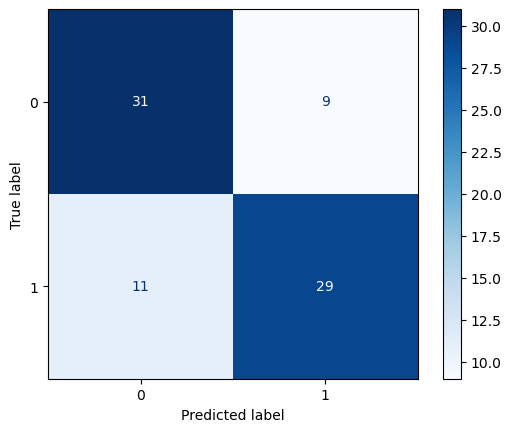

In [78]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

In [79]:
tn, fp, fn, tp = cm.ravel()

print(f"True Positive (TP): {tp} => Data aslinya Positive dan Prediksi juga Positive")
print(f"True Negative (TN): {tn} => Data aslinya Negative dan Prediksi juga Negative")
print(f"False Positive (FP): {fp} => Data aslinya Negative dan Prediksi Positive")
print(f"False Negative (FN): {fn} => Data aslinya Positive dan Prediksi Negative")

True Positive (TP): 29 => Data aslinya Positive dan Prediksi juga Positive
True Negative (TN): 31 => Data aslinya Negative dan Prediksi juga Negative
False Positive (FP): 9 => Data aslinya Negative dan Prediksi Positive
False Negative (FN): 11 => Data aslinya Positive dan Prediksi Negative


## Testing Prediction

In [80]:
s3_key = 'linear-learner-asset/artifact/tfidf_vectorizer.joblib'
local_vectorizer_filename = 'tfidf_vectorizer.joblib'

s3_client = boto3.client('s3')
s3_client.download_file(bucket_name, s3_key, local_vectorizer_filename)

# Load vectorizer dengan joblib
loaded_vectorizer = joblib.load(local_vectorizer_filename)

# Hapus file lokal setelah load
os.remove(local_vectorizer_filename)

In [81]:
# Input text sentimen
input_texts = [
    "waah selamat yah, semoga jadi anak yang soleh/solehah dan berbakti sama orang tua",
    "konten tidak bermutu, mending dihapus aja, membuat orang jadi bodoh!"
]

# Transform pakai vectorizer (harus sama dengan training!)
input_tfidf = loaded_vectorizer.transform(input_texts)

csv_buffer = io.StringIO()
pd.DataFrame(input_tfidf.toarray()).to_csv(csv_buffer, header=False, index=False)
input_csv_string = csv_buffer.getvalue()

# Prediksi ke endpoint (pastikan Content-Type text/csv)
result = predictor.predict(
    input_csv_string,
    initial_args={"ContentType": "text/csv"}
)

# Parse response JSON
response_str = result.decode("utf-8")
data = json.loads(response_str)

preds = [int(item["predicted_label"]) for item in data["predictions"]]

# Tampilkan hasil
for text, label in zip(input_texts, preds):
    sentiment = "Positif" if label == 1 else "Negatif"
    print(f"Input: {text}\nPrediksi: {sentiment}\n")

Input: waah selamat yah, semoga jadi anak yang soleh/solehah dan berbakti sama orang tua
Prediksi: Positif

Input: konten tidak bermutu, mending dihapus aja, membuat orang jadi bodoh!
Prediksi: Negatif

